In [137]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlalchemy
import psycopg2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif

In [69]:
POSTGRES_ADDRESS = 'localhost'
POSTGRES_PORT = '5433'
POSTGRES_USERNAME = 'nick'
POSTGRES_PASSWORD = ''

postgres_str = ('postgresql://{username}:{password}@{ipaddress}:{port}/{dbname}'.format(
   username=POSTGRES_USERNAME, 
    password=POSTGRES_PASSWORD,
    ipaddress=POSTGRES_ADDRESS,
    port=POSTGRES_PORT,
    dbname='project'))
# Create the connection
cnx = sqlalchemy.create_engine(postgres_str)

In [95]:
raw_data = pd.read_sql_query('select * from patient_record order by random() limit 200000', cnx)
raw_data.fillna(0, inplace=True)
raw_data.drop(columns=["as_of_date", "patient_id", 
                       "patient_race", "patient_language", 
                       "patient_gender"], inplace=True)

In [106]:
train_data, test_data = train_test_split(raw_data, test_size=0.2)

# Drop columns with all same values
column_sums = train_data.sum(0)
dropped_columns = []
for i in range(len(column_sums)):
    if column_sums[i] == 0:
        dropped_columns.append(train_data.columns[i])
train_data = train_data.drop(columns=dropped_columns)
test_data = test_data.drop(columns=dropped_columns)

# standardize data
data_mean = train_data.mean()
data_std = train_data.std()
train_data_norm = (train_data - data_mean) / data_std
test_data_norm = (test_data - data_mean) / data_std

# Labels
train_lab_12mo = train_data["fut_admission_12mo"].values
train_lab_6mo = train_data["fut_admission_6mo"].values
train_lab_3mo = train_data["fut_admission_3mo"].values
train_lab_1mo = train_data["fut_admission_1mo"].values
test_lab_12mo = test_data["fut_admission_12mo"].values
test_lab_6mo = test_data["fut_admission_6mo"].values
test_lab_3mo = test_data["fut_admission_3mo"].values
test_lab_1mo = test_data["fut_admission_1mo"].values

# Feature Data
train_features = train_data.drop(columns=[
    "fut_admission_12mo",
    "fut_admission_6mo",
    "fut_admission_3mo",
    "fut_admission_1mo"
])
test_features = test_data.drop(columns=[
    "fut_admission_12mo",
    "fut_admission_6mo",
    "fut_admission_3mo",
    "fut_admission_1mo"
])

no_temp_train_features = train_features["prev_admission"].values.reshape(-1, 1)
no_temp_test_features = test_features["prev_admission"].values.reshape(-1, 1)
temp_train_features = train_features[["prev_admission_12mo", 
                                     "prev_admission_6mo",
                                     "prev_admission_3mo",
                                     "prev_admission_1mo"]]
temp_test_features = test_features[["prev_admission_12mo", 
                                     "prev_admission_6mo",
                                     "prev_admission_3mo",
                                     "prev_admission_1mo"]]

## Comparison of Temporal and Non-Temporal Models

To isolate the effects of adding a temporal factor to our models, we first built models ignoring the features without temporal component on them and focused in on the previous admission features. We created two basic models:

- One model with just the feature "prev_admission", the "non-temporal model
- One model with the same feature broken out into 4 features, prev_admission within 12, 6, 3, and 1 month, the "temporal model"

We created both of these models using a logistic classifier and compared them agains eachother over a range of decision thresholds, using the highest accuracy from each model on a number of response variables, The results are below:

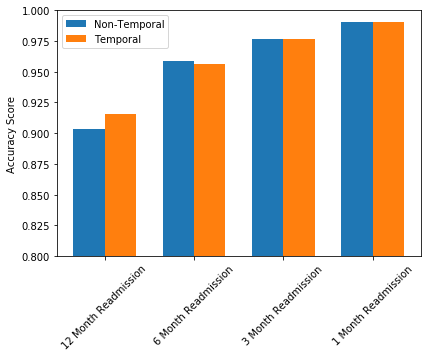

In [159]:
# Compare the two models against eachother

labels = [
    ("12 Month Readmission", train_lab_12mo, test_lab_12mo),
    ("6 Month Readmission", train_lab_6mo, test_lab_6mo),
    ("3 Month Readmission", train_lab_3mo, test_lab_3mo),
    ("1 Month Readmission", train_lab_1mo, test_lab_1mo)
]
names = [x[0] for x in labels]

no_temp_scores = []
temp_scores = []
for period, train_lab_Xmo, test_lab_Xmo in labels:

    no_temp_model = LogisticRegression().fit(no_temp_train_features, train_lab_Xmo)
    temp_model = LogisticRegression().fit(temp_train_features, train_lab_Xmo)

    max_no_temp_score = 0
    max_temp_score = 0
    for thresh in [.05, .1, .2, .3]:
        no_temp_preds = [1 if x[1] > thresh else 0 for x in no_temp_model.predict_proba(no_temp_test_features)]
        no_temp_score = accuracy_score(test_lab_Xmo, no_temp_preds)

        temp_preds = [1 if x[1] > thresh else 0 for x in temp_model.predict_proba(temp_test_features)]
        temp_score = accuracy_score(test_lab_Xmo, temp_preds)
        
        max_no_temp_score = max(max_no_temp_score, no_temp_score)
        max_temp_score = max(max_temp_score, temp_score)
        
    no_temp_scores.append(max_no_temp_score),
    temp_scores.append(max_temp_score)

x = np.arange(len(names))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, no_temp_scores, width, label='Non-Temporal')
rects2 = ax.bar(x + width/2, temp_scores, width, label='Temporal')

ax.set_ylabel('Accuracy Score')
ax.set_xticks(x)
ax.set_xticklabels(names)
ax.legend()
fig.tight_layout()
plt.xticks(rotation=45)
plt.ylim((.8, 1))
plt.show()
        